In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Latent Dim to 512, Base Depth to 6, More Changes"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 512
BASE_DEPTH = 5
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: between 1e-6 and 1e-7

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_zmax0.1_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_zmax0.1_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_zmax0.1_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
# plt.hist(y_train)
# plt.show()

In [9]:
# i = len(x_train) - 1
# while i >= 0:
#     if y_train[i]>=0.1:
#         x_train = np.delete(x_train, i)
#         y_train = np.delete(y_train, i)
#     i -= 1

In [10]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims=1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(images)
        x = Conv2D(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation=None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)
        self.encoder = Model(images, z, name='encoder')

        latents = Input(shape=LATENT_DIM)
        x = Dense(4*LATENT_DIM*8*8, activation=None)(latents)
        x = Reshape((4*LATENT_DIM,8,8))(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 2, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides=1, activation=None, 
                   padding='same', data_format='channels_first')(x)
        outputs = Cropping2D(cropping=((0,1),(0,1)), data_format='channels_first')(x)
        self.decoder = Model(latents, outputs, name='decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [11]:
model = VAE()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 127, 127)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 127, 127)       105       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 64, 64)         105       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 64, 64)         105       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 32, 32)         105       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 32, 32)         105       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 16, 16)         105 

In [12]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-25
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [13]:
history = model.fit(x = x_train, y = x_train, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = (x_validation, x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 427s 62ms/step - loss: 0.4302 - val_loss: 0.2228
Epoch 2/200
313/313 [==============================] - 18s 58ms/step - loss: 0.2253 - val_loss: 0.1957
Epoch 3/200
313/313 [==============================] - 18s 58ms/step - loss: 0.2048 - val_loss: 0.1807
Epoch 4/200
313/313 [==============================] - 21s 66ms/step - loss: 0.1840 - val_loss: 0.1621
Epoch 5/200
313/313 [==============================] - 23s 74ms/step - loss: 0.1728 - val_loss: 0.1542
Epoch 6/200
313/313 [==============================] - 22s 71ms/step - loss: 0.1674 - val_loss: 0.1473
Epoch 7/200
313/313 [==============================] - 18s 58ms/step - loss: 0.1606 - val_loss: 0.1404
Epoch 8/200
313/313 [==============================] - 21s 68ms/step - loss: 0.1553 - val_loss: 0.1374
Epoch 9/200
313/313 [==============================] - 24s 76ms/step - loss: 0.1511 - val_loss: 0.1332
Epoch 10/200
313/313 [==============================] - 20s 64ms/step - 

Epoch 80/200
313/313 [==============================] - 26s 82ms/step - loss: 0.1065 - val_loss: 0.1002
Epoch 81/200
313/313 [==============================] - 28s 90ms/step - loss: 0.1079 - val_loss: 0.0997
Epoch 82/200
313/313 [==============================] - 25s 81ms/step - loss: 0.1079 - val_loss: 0.0996
Epoch 83/200
313/313 [==============================] - 25s 79ms/step - loss: 0.1077 - val_loss: 0.0997
Epoch 84/200
313/313 [==============================] - 24s 78ms/step - loss: 0.1064 - val_loss: 0.0996
Epoch 85/200
313/313 [==============================] - 28s 91ms/step - loss: 0.1073 - val_loss: 0.0999
Epoch 86/200
313/313 [==============================] - 25s 79ms/step - loss: 0.1072 - val_loss: 0.0997
Epoch 87/200
313/313 [==============================] - 24s 78ms/step - loss: 0.1071 - val_loss: 0.0989
Epoch 88/200
313/313 [==============================] - 24s 77ms/step - loss: 0.1069 - val_loss: 0.0998
Epoch 89/200
313/313 [==============================] - 30s 95ms

TypeError: summary() got an unexpected keyword argument 'print_fn'

In [14]:
model.save_weights(weights_path)

In [15]:
model.load_weights(weights_path)

In [16]:
def save_preds(dataset = 'train', num_to_save = None):
    if dataset == 'train':
        datagen = x_train
    elif dataset == 'val':
        datagen = x_validation
    else:
        dataset = 'test'
        datagen = x_test
    preds_path = os.path.join(predictions_path, dataset + "_preds.hdf5")
    print("Saving predictions for", dataset, "dataset in", preds_path)
    
    if num_to_save is None:
        size = len(datagen)
    else:
        size = num_to_save

    with h5py.File(preds_path, 'w') as f:
        f.create_dataset('true', (size, ) + IMAGE_SHAPE)
        f.create_dataset('pred', (size, ) + IMAGE_SHAPE)
        f.create_dataset('loss', (size, ))
        for i in range(size):
            x = datagen[i]
            f['true'][i] = x
            f['pred'][i] = model(np.array([x]))
            f['loss'][i] = model.evaluate(np.array([x]), np.array([x]), verbose = 0)
            stdout.write("\rSaved %d samples of " % (i + 1) + str(size))
            stdout.flush()
            i += 1

In [17]:
save_preds('train')

Saving predictions for train dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221112_01_11_40/train_preds.hdf5
Saved 10000 samples of 10000

In [18]:
save_preds('val')

Saving predictions for val dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221112_01_11_40/val_preds.hdf5
Saved 2000 samples of 2000

In [19]:
save_preds('test')

Saving predictions for test dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221112_01_11_40/test_preds.hdf5
Saved 2000 samples of 2000

In [20]:
def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([x_test[i]])[0][j]))
            pred_array = np.append(pred_array, np.amax(model(np.array([x_test[i]]))[0][j]))
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([x_test[i]])[0][j][63][63])
            pred_array = np.append(pred_array, model(np.array([x_test[i]]))[0][j][63][63])
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Central pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([x_test[i]])[0][j].flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([x_test[i]])[0][j].flatten())
            pred_mean = np.mean(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([x_test[i]])[0][j].flatten())
            pred_arr = sorted(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_arr = true_arr[0:int(len(true_arr)*.99)]
            pred_arr = pred_arr[0:int(len(pred_arr)*.99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha=0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha=0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(0, 5):
        axes[0][i].imshow(np.array([x_test[index]])[0][i])
        max_pixel_true = round(np.amax(np.array([x_test[index]])[0][i]), 2)
        axes[0][i].set_title(f'True band {i} max = ' + str(max_pixel_true))
        pred = model(np.array([x_test[index]]))[0][i]
        axes[1][i].imshow(pred)
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'Pred band {i} max = ' + str(max_pixel_pred))

In [21]:
# scatter_bands_max()

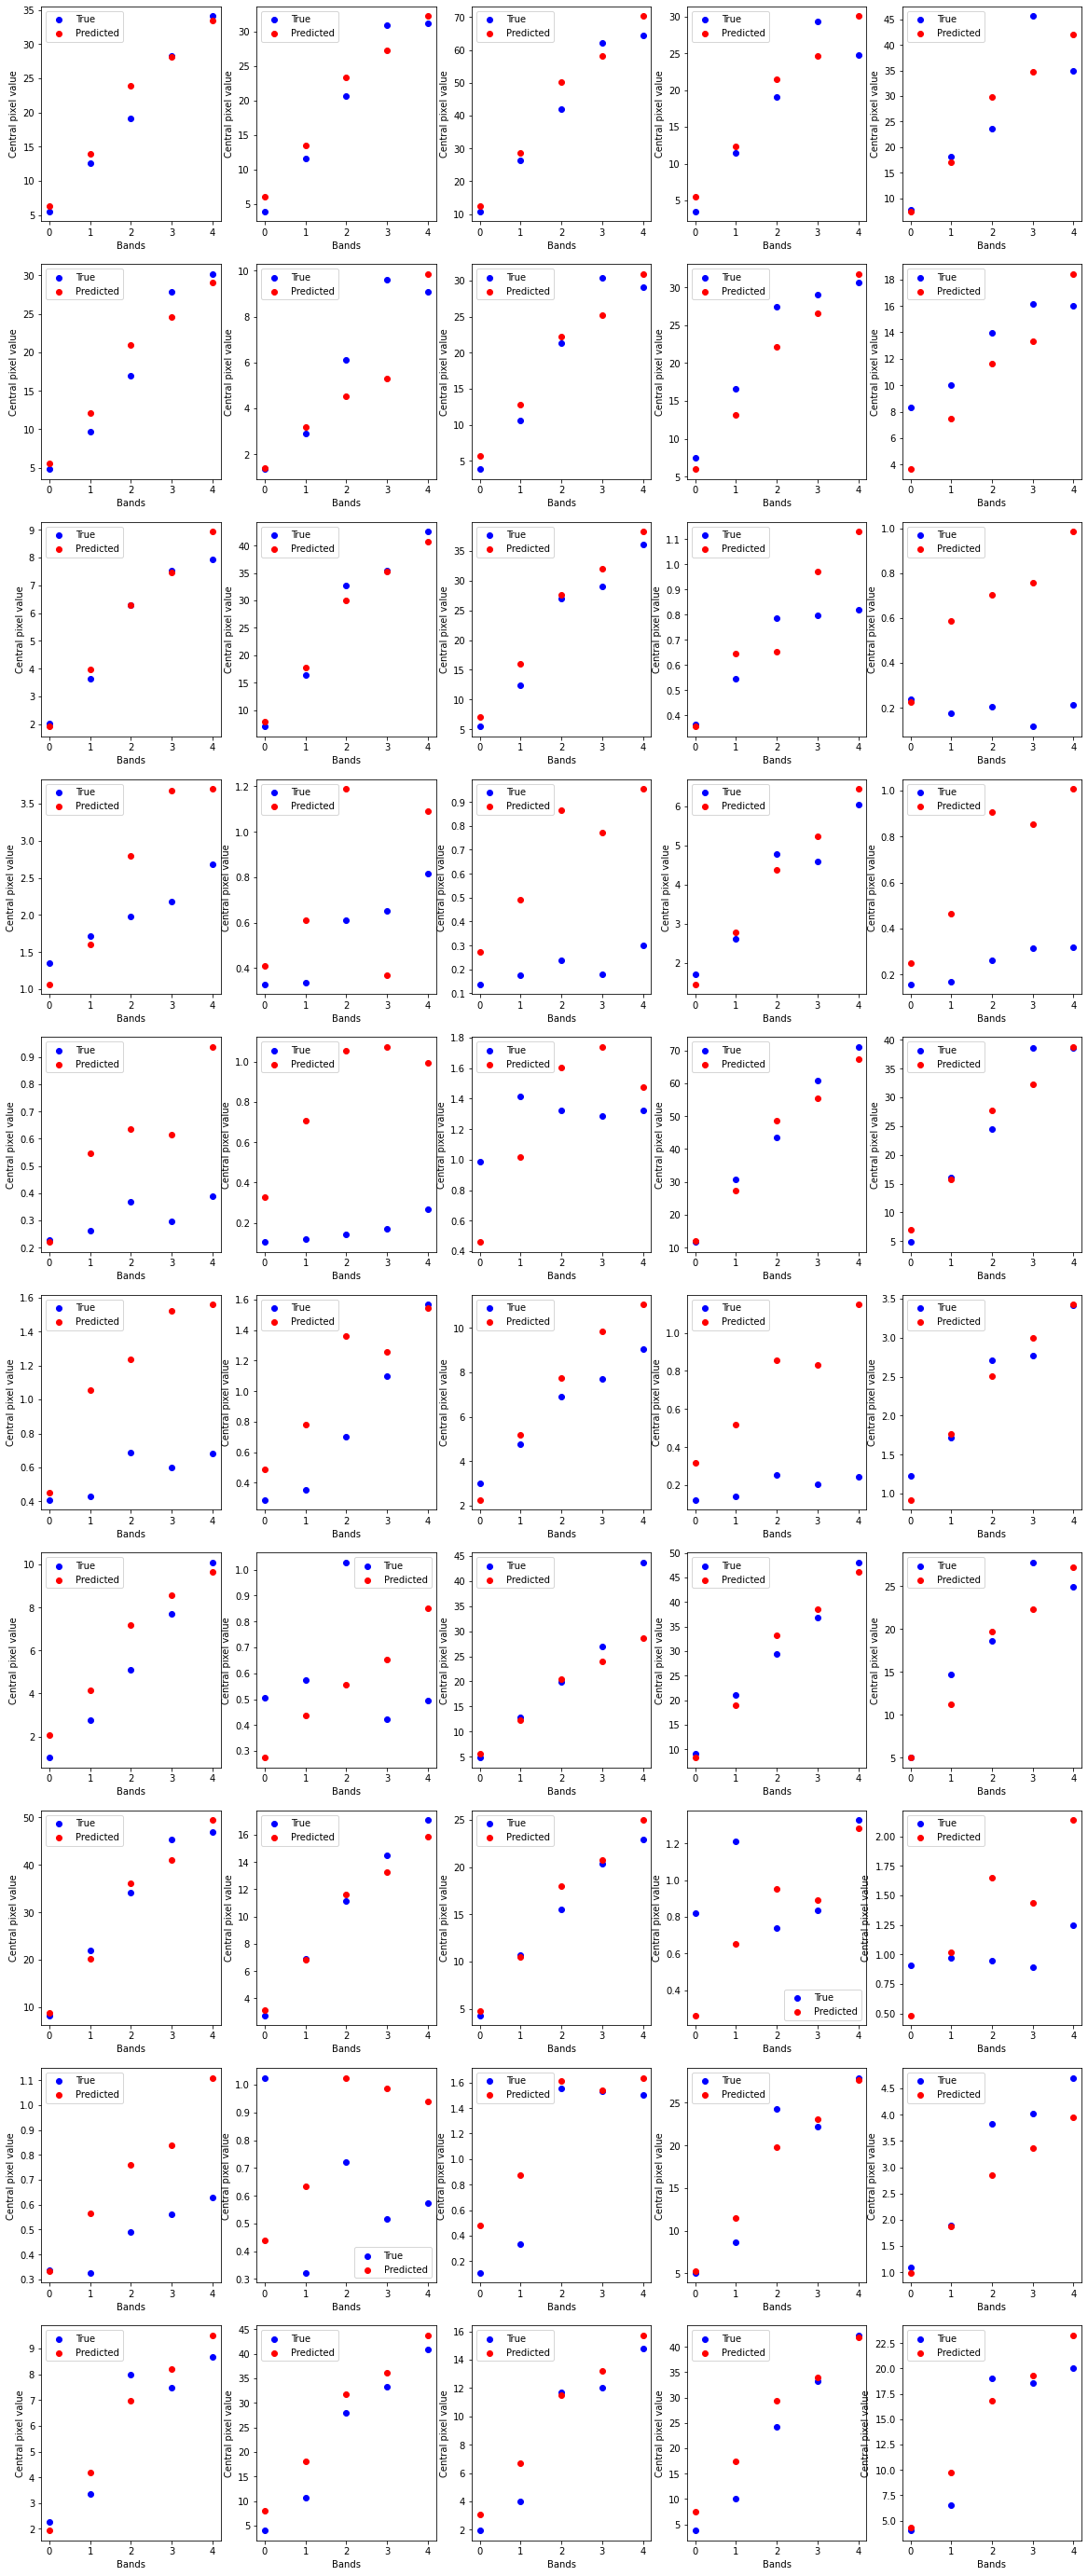

In [22]:
scatter_bands_center(50)

In [23]:
# scatter_bands_mean(10, 0)

In [24]:
# scatter_bands_percentile()

In [25]:
# display_histograms()

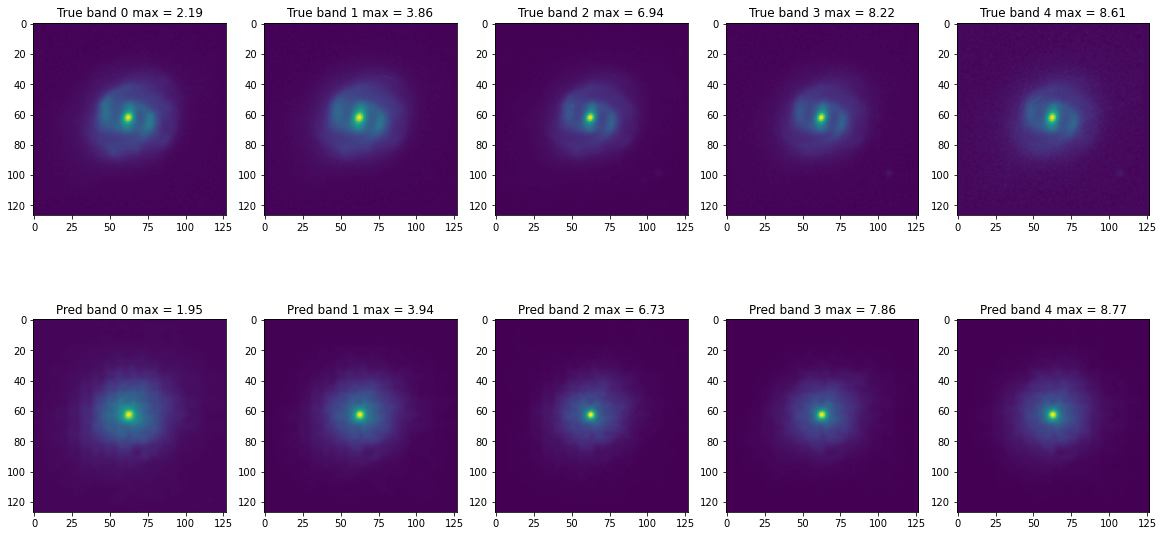

In [26]:
display_5_bands(10)

In [27]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j])
            axes[i][j].set_title(f'Generated image {i} band {j}')

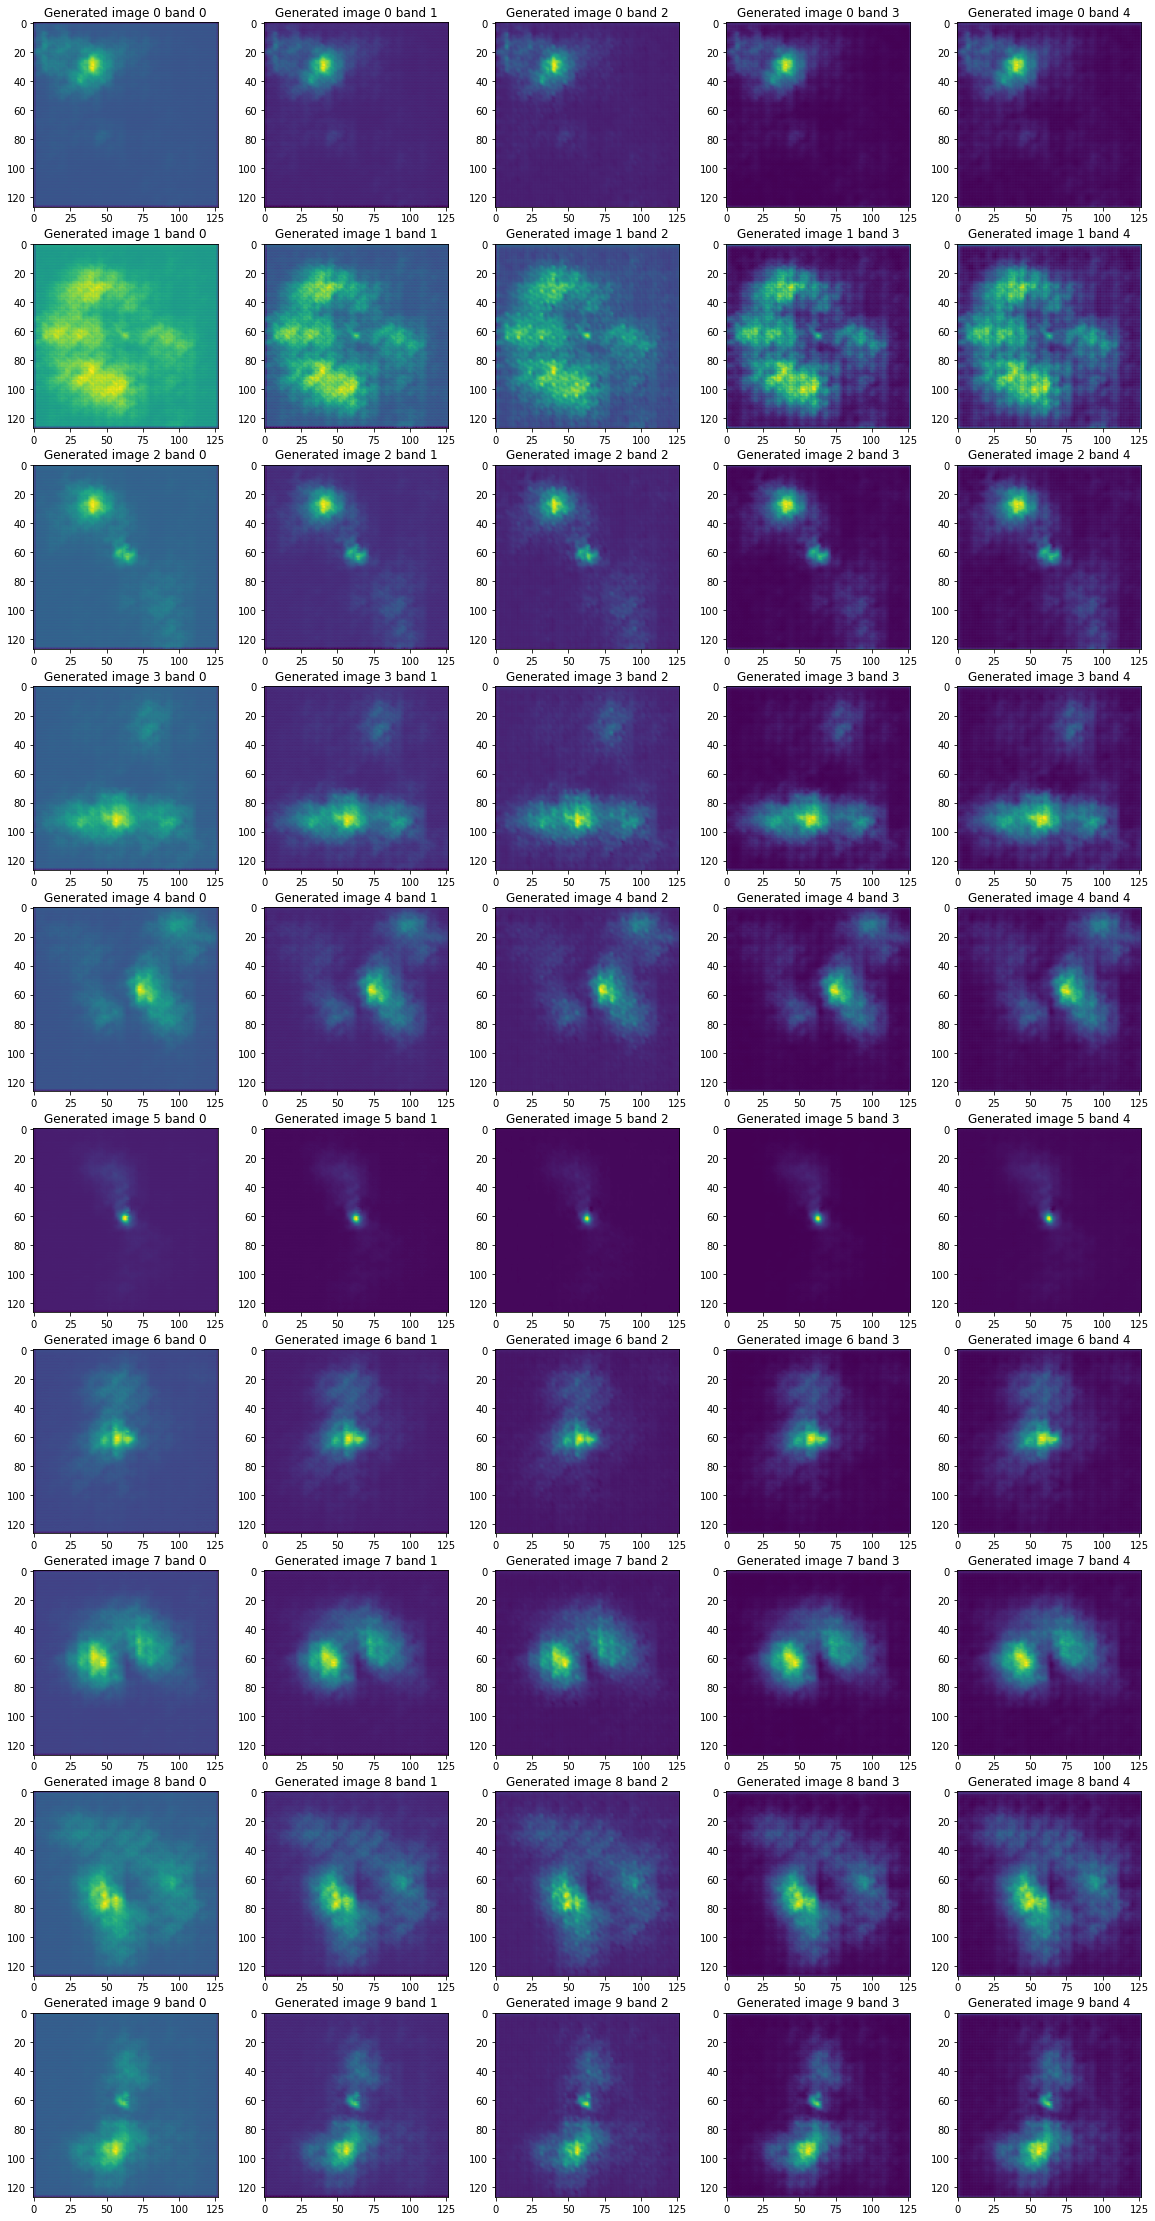

In [30]:
generate_example_galaxies(10)

In [29]:
# END